In [17]:
import xarray
import fsspec
import numpy as np
#import s3fs
import proplot
import os
import gsw as TEOS_10

from matplotlib import pyplot as plt
import pandas

In [2]:
def Get_CODA_id(dates,source_data,obs_platform,year):
    
    CODA_id_length = 20
    CODA_ID = np.array(['' for _ in range(dates.size)], dtype='S{}'.format(CODA_id_length))
    
    unique_dates = np.unique(CODA_dates)

    
    for i_date in unique_dates:
    
        if not pandas.isnull(i_date):
            
            idx_for_date   =  np.nonzero(dates == i_date)[0]
            count_for_date =  idx_for_date.size
            i_profile = 1
            
            for i_index in idx_for_date:
                #print(i_index)
                CODA_id_current_profiles = source_data + obs_platform + i_date.strftime('%Y%m%d') + f'{i_profile:04}'
                CODA_ID[i_index] = CODA_id_current_profiles
                i_profile = i_profile+1
                
            #END for i_index
        #if not isnull
    #END for i_date

    bad_dates_idx = np.nonzero(pandas.isnull(dates))[0]
 
    bad_profile_counter = 1
    
    for i_bad_idx in bad_dates_idx:
        CODA_id_current_profiles = source_data + obs_platform + str(year) + 'XXXX' + f'{bad_profile_counter:04}'
        CODA_ID[i_bad_idx] = CODA_id_current_profiles
        bad_profile_counter = bad_profile_counter+1

    return CODA_ID

In [3]:
#Get list of netcdf files
mnf_base_dir = '/oa-decadal-climate/work/observations/CARSv2_ancillary/data_cars/MNFtrawlerCTD'

mnf_ctd_files = os.listdir(mnf_base_dir)

mnf_ctd_files_to_get = []
for i_file in mnf_ctd_files:
    
    if os.path.isfile(os.path.join(mnf_base_dir,i_file)) and os.path.join(mnf_base_dir,i_file).endswith('.nc'):
        mnf_ctd_files_to_get.append(os.path.join(mnf_base_dir,i_file))
        
    

In [4]:
ctd_time = np.zeros(len(mnf_ctd_files_to_get),'datetime64[ns]')

file_counter = 0
for i_file in mnf_ctd_files_to_get:
    ctd_dataset = xarray.open_dataset(i_file)
    ctd_time[file_counter]    = ctd_dataset['TIME'].values
    ctd_dataset.close()
    file_counter = file_counter+1
    

mnf_ctd_files_to_get_sorted = []


time_sorted_idx = np.argsort(ctd_time)

for i_index in time_sorted_idx:
    mnf_ctd_files_to_get_sorted.append( mnf_ctd_files_to_get[i_index])
    
ctd_time             = ctd_time[time_sorted_idx]
years = ctd_time.astype('datetime64[Y]').astype(int) + 1970
unique_years = np.unique(years)

In [5]:
CODA_to_mnf_key = {'Temperature':'TEMP',
                   'Salinity':'PSAL',
                   'Oxygen':'DOXY',
                   'z':'DEPTH'}  #Temperature','Oxygen','Salinity'

In [6]:
ds = xarray.open_dataset(mnf_ctd_files_to_get_sorted[2])

In [7]:
ds['DOXY_quality_control']

<xarray.DataArray 'DOXY_quality_control' (PRES_REL: 2118)>
array([9., 9., 9., ..., 9., 9., 9.], dtype=float32)
Coordinates:
  * PRES_REL   (PRES_REL) float32 8.0 10.0 12.0 ... 4.238e+03 4.24e+03 4.242e+03
    TIME       datetime64[ns] ...
    LATITUDE   float64 ...
    LONGITUDE  float64 ...
Attributes:
    long_name:                    quality flag for mole_concentration_of_diss...
    standard_name:                mole_concentration_of_dissolved_molecular_o...
    quality_control_conventions:  IMOS standard flags
    valid_min:                    0
    valid_max:                    9
    flag_values:                  [0 1 2 3 4 5 6 7 8 9]
    flag_meanings:                No_QC_performed Good_data Probably_good_dat...

In [26]:
output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2'

hard_code_output = {'country':'Australia',
                    'dbase_orig':'CSIRO Oracle Database',
                    'Institute':'Marine National Facility',
                    'Temperature_Instrument':'CTD'}

platform_key = {'SS': 'Southern Surveyor (R/V)',
                'AU': 'Aurora Australis (Icebr.)',
                'IN': 'Investigator (R/V)',
                'SO': 'Solander (R/V)',
                'ST':'Southern Surveyor (R/V)'}

            



WOD_CODA_reference_file_name = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2/2015/WOD_CODA_2015_ctd_test_all_vars.nc'
WOD_CODA_reference_dataset   = xarray.open_dataset(WOD_CODA_reference_file_name)

vars_to_get = ['z','Temperature','Oxygen','Salinity']
ancillary_vars_to_get = ['Platform','Project']
FILL_VALUE = -10000000000.0


for i_year in unique_years:
    print(i_year)
    vars_to_get_for_platform = []
    
            
    idx_for_year = np.nonzero(years==i_year)[0]
    n_profiles   = idx_for_year.size

    
    max_depth_levels = 0
    
    for i_file_for_year in idx_for_year:
        mnf_ctd_dataset = xarray.open_dataset(mnf_ctd_files_to_get_sorted[i_file_for_year])
        current_row_size = mnf_ctd_dataset['PRES_REL'].size
        
        if current_row_size>max_depth_levels:
            max_depth_levels = current_row_size
        mnf_ctd_dataset.close()
    #END for i_file_for_year
    
    
    
    data_container_for_year            = {}
    attributes_data_container_for_year = {}
    attribute_container_for_year       = {}

    for i_var in vars_to_get:
        data_container_for_year[i_var]               = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='float32')
        data_container_for_year[i_var + '_origflag'] = np.nan*np.zeros([n_profiles,max_depth_levels],dtype='int16')
        attribute_container_for_year[i_var]          = {}
    
    data_container_for_year['lat']  = np.nan*np.zeros([n_profiles],dtype='float32')
    data_container_for_year['lon']  = np.nan*np.zeros([n_profiles],dtype='float32')
    data_container_for_year['time'] = np.zeros([n_profiles],dtype='datetime64[ns]')
    
    attribute_container_for_year['lat'] = {}
    attribute_container_for_year['lon'] = {}
    attribute_container_for_year['time'] = {}

    
    ancillary_var_data_container_for_year = {}
    
    for i_ancillary_var in ancillary_vars_to_get:
        data_container_for_year[i_ancillary_var] =  np.zeros([n_profiles],dtype='S{}'.format(100))
        attribute_container_for_year[i_ancillary_var] = {}
    
    
    
    files_used_for_year = ' '

    cast_counter = 0
    for i_file_for_year in idx_for_year:
        
        #rint(mnf_ctd_files_to_get_sorted[i_file_for_year])
        current_file_name = os.path.basename(mnf_ctd_files_to_get_sorted[i_file_for_year])
        
        mnf_ctd_dataset = xarray.open_dataset(mnf_ctd_files_to_get_sorted[i_file_for_year])
        files_used_for_year = files_used_for_year + ' ' + os.path.basename(mnf_ctd_files_to_get_sorted[i_file_for_year])
        
        
        for i_var in vars_to_get:
            
            i_mnf_var_name = CODA_to_mnf_key[i_var]
            variables_in_dataset = mnf_ctd_dataset.variables.keys()
            
            if i_mnf_var_name in variables_in_dataset:
                
                current_profile = mnf_ctd_dataset[i_mnf_var_name].values
                if i_var == 'z':
                    current_profile = TEOS_10.z_from_p(current_profile,mnf_ctd_dataset['LATITUDE'].values)
                #END if i_var == z
                
                data_container_for_year[i_var][cast_counter,0:current_profile.size] = current_profile
            #END if i_mnf_var_name in  variables_in_dataset
            
            
            if i_mnf_var_name +  '_quality_control' in variables_in_dataset:
                
                current_QC_profile = mnf_ctd_dataset[i_mnf_var_name + '_quality_control' ].values
                data_container_for_year[i_var + '_origflag'][cast_counter,0:current_QC_profile.size] = current_QC_profile

            #END if i_var
            
            if cast_counter==0:
                variable_attributes = WOD_CODA_reference_dataset[i_var].attrs.keys()
                
                for i_attribute in variable_attributes:
                    if i_attribute != 'ancillary_variables':
                        attribute_container_for_year[i_var][i_attribute] = WOD_CODA_reference_dataset[i_var].attrs[i_attribute]
                    else:
                        attribute_container_for_year[i_var][i_attribute] = i_var + '_origflag'
                
                
        #END for i_var
        data_container_for_year['lon'][cast_counter] = mnf_ctd_dataset['LONGITUDE'].values
        data_container_for_year['lat'][cast_counter] = mnf_ctd_dataset['LATITUDE'].values
        data_container_for_year['time'][cast_counter] = mnf_ctd_dataset['TIME'].values
        
        if cast_counter ==0:
            attribute_container_for_year['lon'] = WOD_CODA_reference_dataset['lon'].attrs
            attribute_container_for_year['lat'] = WOD_CODA_reference_dataset['lat'].attrs
            attribute_container_for_year['time'] = WOD_CODA_reference_dataset['time'].attrs

        #=======================================================================#
        current_platform  = platform_key[current_file_name[0:2]]
        
        data_container_for_year['Platform'][cast_counter] = current_platform
        data_container_for_year['Project'][cast_counter]  = mnf_ctd_dataset.attrs['project']
        
        
        for i_ancillary_var in ancillary_vars_to_get:

            variable_attributes = WOD_CODA_reference_dataset[i_ancillary_var].attrs.keys()
            for i_attribute in variable_attributes:
                attribute_container_for_year[i_var][i_attribute] = WOD_CODA_reference_dataset[i_ancillary_var].attrs[i_attribute]
            #for i_attribute
        #END for i_ancillary
        mnf_ctd_dataset.close()
        cast_counter = cast_counter+1
    #END i_file
    
    cast_index = np.arange(0,n_profiles,1)

    
    CODA_output_dataset   = xarray.DataArray(data_container_for_year['lat'],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year['lat'])
    
    CODA_output_dataset   = CODA_output_dataset.to_dataset(name='lat')
    
    CODA_output_dataset['lon']  = xarray.DataArray(data_container_for_year['lon'],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year['lon'])
    CODA_output_dataset['time']       = xarray.DataArray(data_container_for_year['time'],dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year['time'])
    CODA_output_dataset['time'].encoding['units'] = 'days since 1770-01-01T00:00:00+00:00'

    for i_var in vars_to_get:
        CODA_output_dataset[i_var]   = xarray.DataArray(data_container_for_year[i_var],dims=['cast','z_index'],
                                      coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)},
                                      attrs = attribute_container_for_year[i_var])
        
        CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(FILL_VALUE)

        CODA_output_dataset[i_var+'_origflag']   = xarray.DataArray(data_container_for_year[i_var+'_origflag'],dims=['cast','z_index'],
                                      coords= {'cast':cast_index,'z_index':np.arange(0,max_depth_levels,1)},
                                      attrs = attribute_container_for_year[i_var])
        CODA_output_dataset[i_var] = CODA_output_dataset[i_var].fillna(int(FILL_VALUE))



    
    
    for i_ancillary_var in ancillary_vars_to_get:
        CODA_output_dataset[i_ancillary_var]  = xarray.DataArray(data_container_for_year[i_ancillary_var],dims=['cast'],coords={'cast':cast_index},
                                                                   attrs = attribute_container_for_year[i_ancillary_var])
    #END for i_ancillary_var
    
    for i_hard_code_ancillary_var in hard_code_output.keys():
        hard_code_ancillary_data_array = np.zeros([n_profiles],dtype='S{}'.format(100))
        for i_cast in range(0,n_profiles):
            hard_code_ancillary_data_array[i_cast] = hard_code_output[i_hard_code_ancillary_var]
        #END i_cast
        hard_code_attributes = WOD_CODA_reference_dataset[i_hard_code_ancillary_var].attrs
        CODA_output_dataset[i_hard_code_ancillary_var]  = xarray.DataArray(hard_code_ancillary_data_array,dims=['cast'],coords={'cast':cast_index},
                                                                   attrs = hard_code_attributes)
    #END for i_hard_code_anancillary_var
    

    source_data = 'mnf'
    obs_type  = 'ctd'
    
    CODA_dates    = CODA_output_dataset['time'].dt.date.values

    CODA_ID = Get_CODA_id(CODA_dates,source_data,obs_type,i_year)
        
        
    CODA_output_dataset['CODA_id'] = xarray.DataArray(CODA_ID,dims=['cast'],coords={'cast':cast_index},
                                                          attrs={'Comment':'Unique CODA identifier with format <Source Dataset><Obs Platform><YYYYMMDD><Counter for date>'})

    CODA_output_dataset.attrs = {'Parent files':files_used_for_year}

    
    output_file_name = 'MNF_CODA_' + str(i_year) + '_' + str(obs_type) + '_test_all_vars.nc'
    print('Writing file:', output_file_name)
    
    encoding = {
            'Temperature': {'_FillValue': FILL_VALUE},
            'Salinity':    {'_FillValue':  FILL_VALUE},
            'Oxygen':      {'_FillValue':  FILL_VALUE},
            'z':           {'_FillValue':  FILL_VALUE}
            }
    
    
    if not os.path.isdir(os.path.join(output_path,str(i_year))):
        os.mkdir(os.path.join(output_path,str(i_year)))
    CODA_output_dataset.to_netcdf(os.path.join(output_path,str(i_year),output_file_name),encoding=encoding) #,engine='netcdf4')
    

2005
Writing file: MNF_CODA_2005_ctd_test_all_vars.nc
2006
Writing file: MNF_CODA_2006_ctd_test_all_vars.nc
2007
Writing file: MNF_CODA_2007_ctd_test_all_vars.nc
2008
Writing file: MNF_CODA_2008_ctd_test_all_vars.nc
2009
Writing file: MNF_CODA_2009_ctd_test_all_vars.nc
2010
Writing file: MNF_CODA_2010_ctd_test_all_vars.nc
2011
Writing file: MNF_CODA_2011_ctd_test_all_vars.nc
2012
Writing file: MNF_CODA_2012_ctd_test_all_vars.nc
2013
Writing file: MNF_CODA_2013_ctd_test_all_vars.nc
2014
Writing file: MNF_CODA_2014_ctd_test_all_vars.nc
2015
Writing file: MNF_CODA_2015_ctd_test_all_vars.nc
2016
Writing file: MNF_CODA_2016_ctd_test_all_vars.nc
2017
Writing file: MNF_CODA_2017_ctd_test_all_vars.nc
2018
Writing file: MNF_CODA_2018_ctd_test_all_vars.nc
2019
Writing file: MNF_CODA_2019_ctd_test_all_vars.nc
2020
Writing file: MNF_CODA_2020_ctd_test_all_vars.nc
2021
Writing file: MNF_CODA_2021_ctd_test_all_vars.nc
2022
Writing file: MNF_CODA_2022_ctd_test_all_vars.nc
2023
Writing file: MNF_CODA_

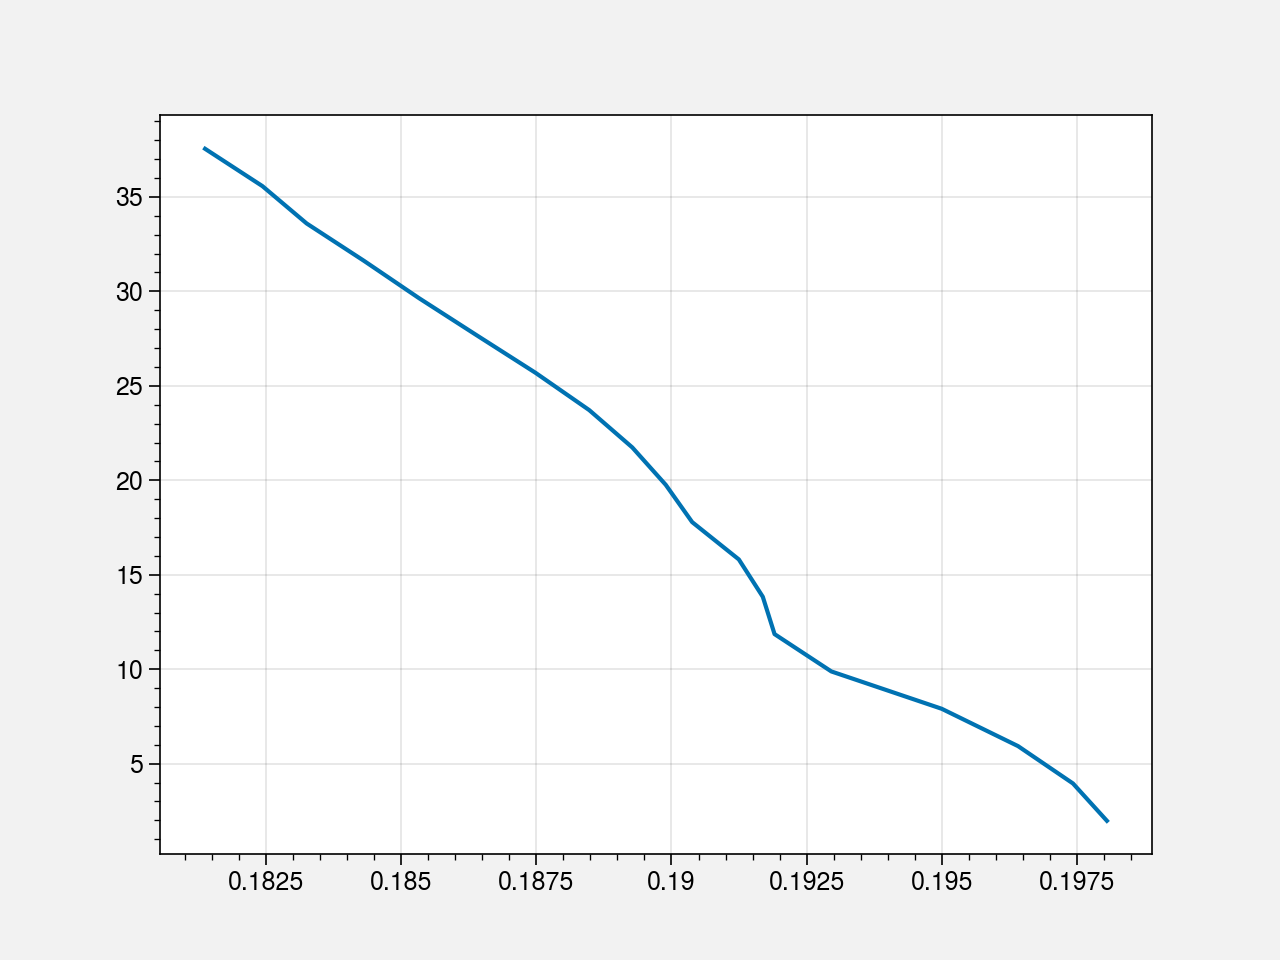

In [25]:
i_cast = 60

T = CODA_output_dataset['Oxygen'][i_cast]
z = CODA_output_dataset['z'][i_cast]

nan_mask = T==FILL_VALUE
T[nan_mask] = np.nan
z[nan_mask] = np.nan
plt.plot(T,-z)

In [69]:
CODA_output_dataset

<xarray.Dataset>
Dimensions:                 (cast: 320, z_index: 4344)
Coordinates:
  * cast                    (cast) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
  * z_index                 (z_index) int64 0 1 2 3 4 ... 4340 4341 4342 4343
Data variables: (12/17)
    lat                     (cast) float32 -45.01 -44.49 -45.5 ... -21.96 -20.99
    lon                     (cast) float32 115.0 115.0 115.0 ... 113.8 114.4
    time                    (cast) datetime64[ns] 2005-01-01T00:24:52 ... 200...
    z                       (cast, z_index) float64 1.984 3.967 ... -1e+10
    z_origflag              (cast, z_index) float64 nan nan nan ... nan nan nan
    Temperature             (cast, z_index) float64 11.48 11.49 ... -1e+10
    ...                      ...
    Platform                (cast) |S100 b'Aurora Australis (Icebr.)' ... b'S...
    Project                 (cast) |S100 b'AU200403' b'AU200403' ... b'SS200510'
    country                 (cast) |S100 b'Australia' ... b'Australia'
    dbase_orig              (cast) |S100 b'CSIRO Oracle Database' ... b'CSIRO...
    Institute               (cast) |S100 b'Marine National Facility' ... b'Ma...
    Temperature_Instrument  (cast) |S100 b'CTD' b'CTD' b'CTD' ... b'CTD' b'CTD'

In [11]:
data_container_for_year.keys()

dict_keys(['z', 'z_origflag', 'Temperature', 'Temperature_origflag', 'Oxygen', 'Oxygen_origflag', 'Salinity', 'Salinity_origflag', 'lat', 'lon', 'time', 'Platform', 'Project'])

In [69]:
mnf_ctd_dataset

<xarray.Dataset>
Dimensions:                    (PRES_REL: 253)
Coordinates:
  * PRES_REL                   (PRES_REL) float32 2.0 4.0 6.0 ... 504.0 506.0
    TIME                       datetime64[ns] 2014-04-25T11:23:45.000000256
    LATITUDE                   float64 -9.775
    LONGITUDE                  float64 127.6
Data variables: (12/15)
    LATITUDE_quality_control   float32 ...
    LONGITUDE_quality_control  float32 ...
    BOT_DEPTH                  float64 ...
    DEPTH                      (PRES_REL) float32 1.989 3.977 ... 500.5 502.5
    TRANS                      (PRES_REL) float32 ...
    TRANS_quality_control      (PRES_REL) float32 ...
    ...                         ...
    PSAL_quality_control       (PRES_REL) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    TEMP                       (PRES_REL) float32 29.99 29.99 ... 7.787 7.795
    TEMP_quality_control       (PRES_REL) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    PAR                        (PRES_REL) float32 ...
    PAR_quality_control        (PRES_REL) float32 ...
    TIME_quality_control       float32 ...
Attributes: (12/21)
    Conventions:                   CF-1.6,IMOS-1.4
    acknowledgement:               We acknowledge the use of the CSIRO Marine...
    author:                        Rebecca Cowley
    author_email:                  Rebecca.Cowley@csiro.au
    citation:                      Created from data extracted by NCMI staff ...
    disclaimer:                    Data is supplied 'as is' without any warra...
    ...                            ...
    project:                       SOL_5941
    station:                       17
    site_code:                     14559.0
    unique_code:                   171ed655-5b38-66fd-e053-08114f8c70ac
    date_created:                  2023-09-21T11:56:57Z
    date_modified:                 2023-09-21T11:56:57Z

In [52]:
    for i_ancillary_var in ancillary_vars_to_get:
        ancillary_data_array = np.zeros([n_casts],dtype='S{}'.format(100))
        for i_cast in range(0,n_casts):
            ancillary_data_array[i_cast] = ancillary_var_data_container_for_year[i_ancillary_var][i_cast]
            
        CODA_output_dataset[i_ancillary_var]  = xarray.DataArray(ancillary_data_array,dims=['cast'],coords={'cast':cast_index},
                                                                    attrs = attribute_container_for_year[i_ancillary_var])
    
 

In [54]:
CODA_output_dataset['Platform']

<xarray.DataArray 'Platform' (cast: 320)>
array([b'Aurora Australis (Icebr.)', b'Aurora Australis (Icebr.)',
       b'Aurora Australis (Icebr.)', b'Aurora Australis (Icebr.)',
       b'Aurora Australis (Icebr.)', b'Aurora Australis (Icebr.)',
       b'Aurora Australis (Icebr.)', b'Aurora Australis (Icebr.)',
       b'Aurora Australis (Icebr.)', b'Aurora Australis (Icebr.)',
       b'Aurora Australis (Icebr.)', b'Aurora Australis (Icebr.)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Aurora Australis (Icebr.)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
...
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)',
       b'Southern Surveyor (R/V)', b'Southern Surveyor (R/V)'],
      dtype='|S100')
Coordinates:
  * cast     (cast) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

In [17]:
os.path.join(output_path,str(i_year),output_file_name)

'/tube1/cha674/CARS_2022/cars-v2/CODA_test/2005/MNF_CODA_2005_ctd_test_all_vars.nc'

In [12]:
test_dataset = xarray.open_dataset(os.path.join(output_path,str(i_year),output_file_name),mask_and_scale=True)

In [ ]:
test_dataset


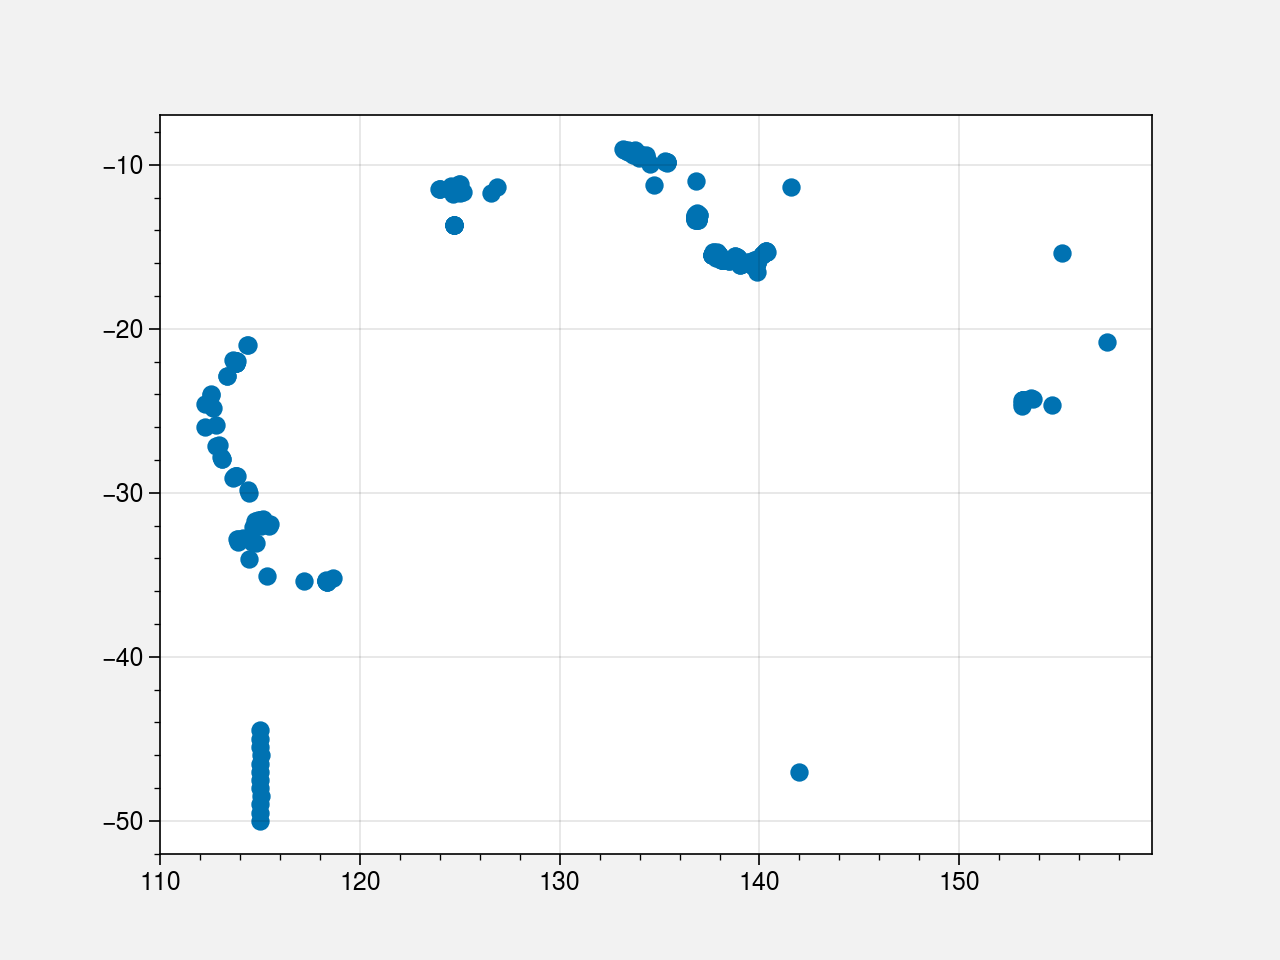

In [26]:
plt.scatter(test_dataset.longitude,test_dataset.latitude)

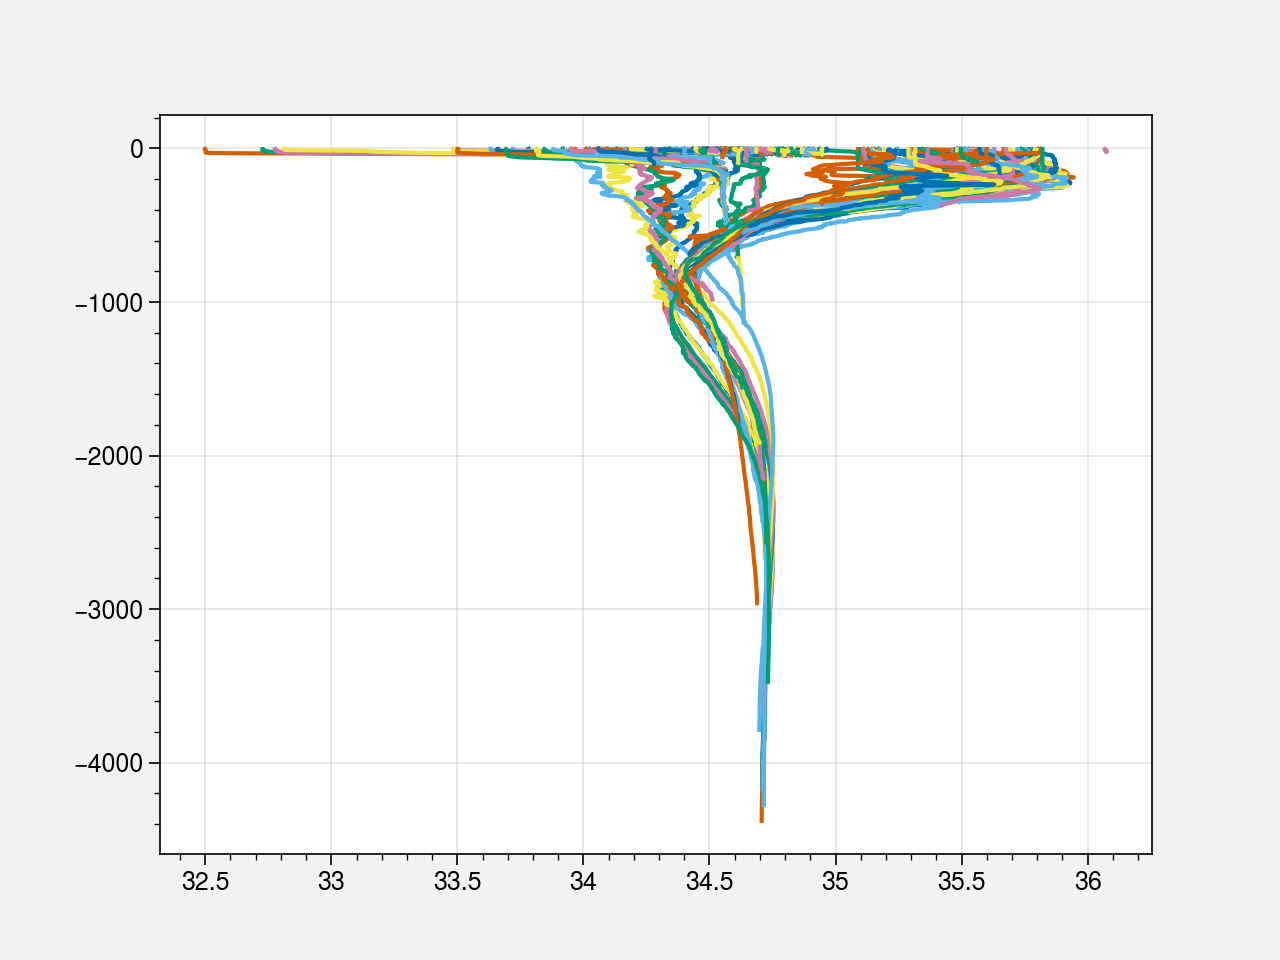

In [13]:
i_cast = 80
plt.plot(CODA_output_dataset['Salinity'].values.T,-CODA_output_dataset['z'].values.T)

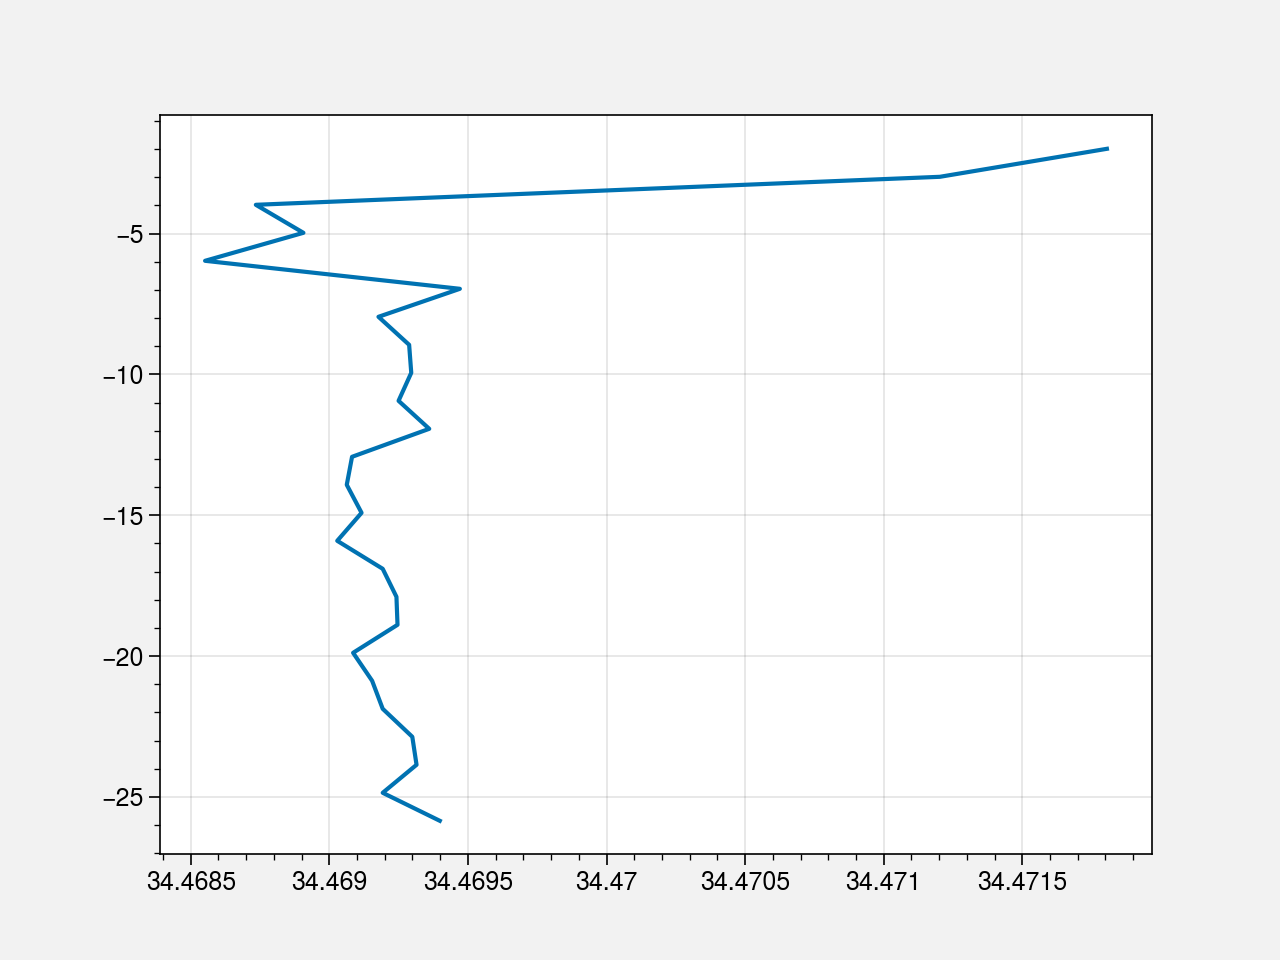

In [267]:
i_cast = 200
plt.plot(CODA_output_dataset['Salinity'][i_cast,:],-CODA_output_dataset['z'][i_cast,:])

In [207]:
var_in_dataset['Oxygen']

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

<xarray.DataArray 'Oxygen' (z_index: 4344)>
array([ 2.9023e-01,  2.9036e-01,  2.9042e-01, ..., -9.9990e+03,
       -9.9990e+03, -9.9990e+03], dtype=float32)
Coordinates:
    cast     int64 4
  * z_index  (z_index) int64 0 1 2 3 4 5 6 ... 4338 4339 4340 4341 4342 4343
Attributes:
    long_name:            mole_concentration_of_dissolved_molecular_oxygen_in...
    standard_name:        mole_concentration_of_dissolved_molecular_oxygen_in...
    units:                mol m-3
    valid_min:            0.0
    valid_max:            0.6
    ancillary_variables:  DOXY_quality_control
    axis:                 Z
    positive:             down
    _FillValue:           -9999

In [153]:
data_container_for_year.keys()

dict_keys(['z', 'z_origflag', 'Temperature', 'Temperature_origflag', 'Oxygen', 'Oxygen_origflag', 'Salinity', 'Salinity_origflag', 'lat', 'lon', 'time'])

In [145]:
i_var

'z'

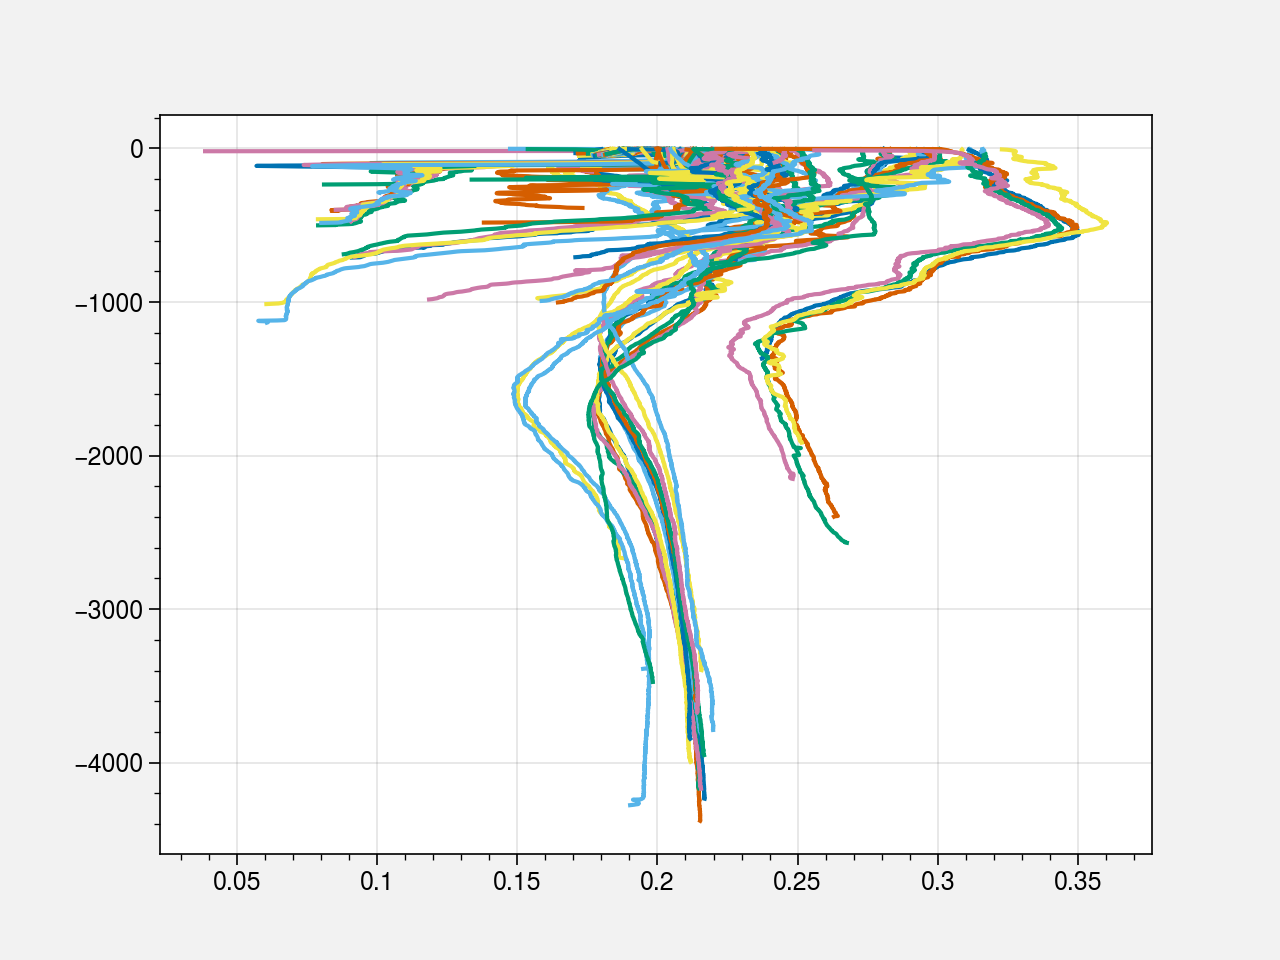

In [132]:
plt.plot(CODA_output_dataset['Oxygen'].values.T,-CODA_output_dataset['z'].T)

In [119]:
len(data_container_for_year['Oxygen'])

320

In [117]:
CODA_output_dataset

<xarray.Dataset>
Dimensions:      (cast: 320, z_index: 4344)
Coordinates:
  * cast         (cast) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * z_index      (z_index) int64 0 1 2 3 4 5 6 ... 4338 4339 4340 4341 4342 4343
Data variables:
    z            (cast, z_index) float32 1.984 3.967 5.951 7.935 ... nan nan nan
    Temperature  (cast, z_index) float32 11.48 11.49 11.49 11.48 ... nan nan nan
    Salinity     (cast, z_index) float32 34.61 34.61 34.61 34.61 ... nan nan nan

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: setting an array element with a sequence.

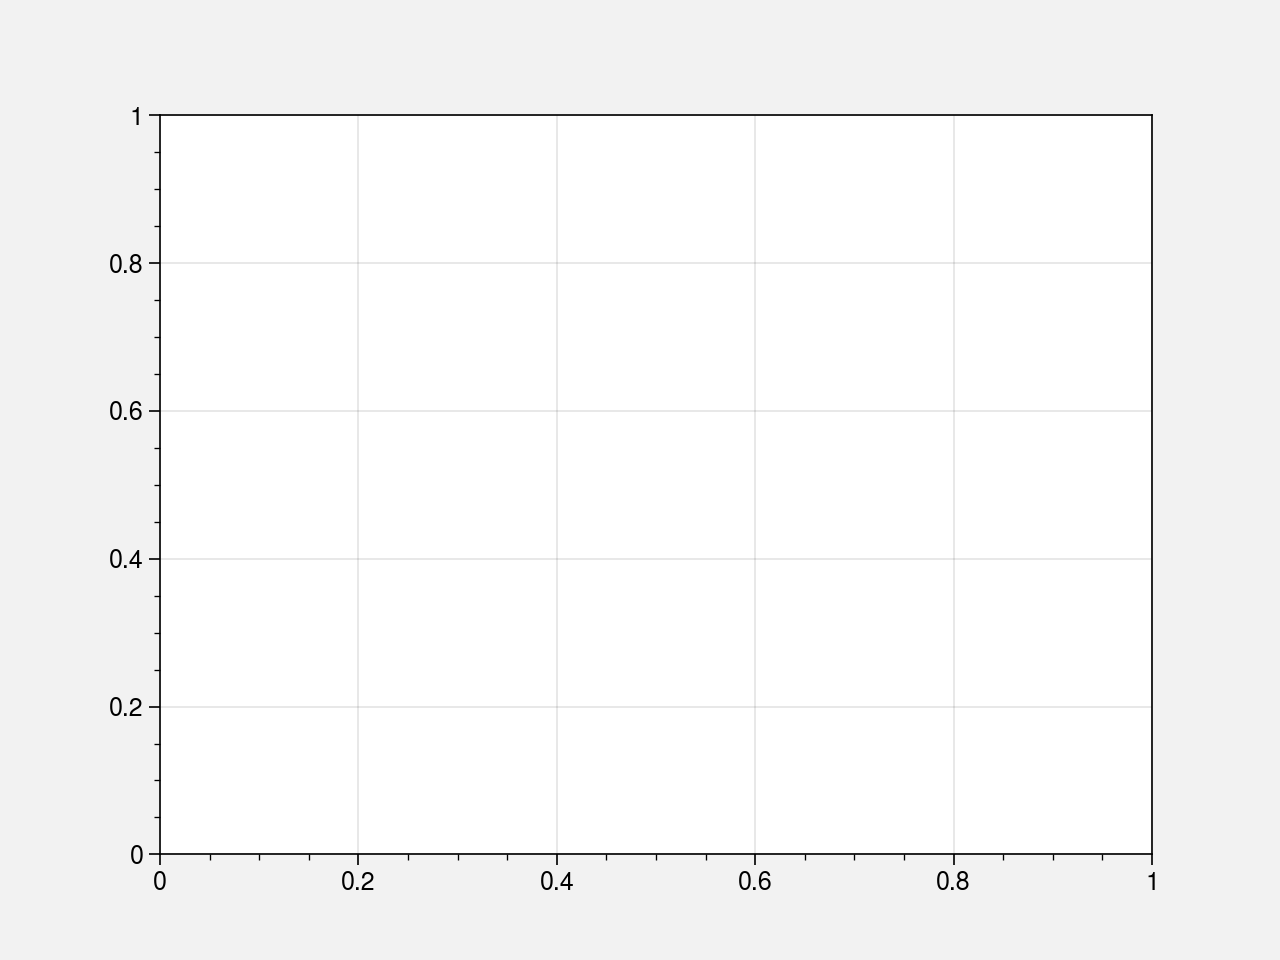

In [97]:
plt.plot(np.asarray(data_container_for_year['Temperature']),-np.asarray(data_container_for_year['z']))

In [ ]:
ctd_time[1]